In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [103]:
data = pd.read_csv('SMSSpamCollection', sep = '\t', header = None)
data.columns = ['Label', 'Message']
data.head(10)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [104]:
print(data.shape)

(5572, 2)


In [105]:
def get_wordnet_pos(tag):
  if tag.startswith('J'):
    return 'a'
  elif tag.startswith('V'):
    return 'v'
  elif tag.startswith('N'):
    return 'n'
  elif tag.startswith('R'):
    return 'r'
  else:
    return 'n'

english_vocab = set(w.lower() for w in nltk.corpus.words.words())

data_np = data.to_numpy()
data_normalized = []
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
all_words = []
i = 0
for row in data_np:
  target = row[0]
  message = row[1]
  message_lower = message.lower()
  message_lower = re.sub(r'\W', ' ', message_lower)
  message_lower = re.sub(r'\s+', ' ', message_lower)
  words = nltk.word_tokenize(message_lower)
  message_pos_tokens = nltk.pos_tag(words)
  words_without_stopwords = []
  for word, tag in message_pos_tokens:
    if(word not in stop_words and word in english_vocab):
      # TODO: Add some logic to fix spellings/accronyms etc
      word_lemmatized = lemmatizer.lemmatize(word, get_wordnet_pos(tag))
      words_without_stopwords.append(word_lemmatized)
      all_words.append(word_lemmatized)
  message_normzalized = " ".join(words_without_stopwords)
  data_normalized.append([target, message_normzalized])
words_set = set(all_words)
vocab_size = len(words_set)
print(vocab_size)

3608


In [106]:
# Deciding length of words to create features later
message_length_count = {}
spam_message_length_count = {}
for data in data_normalized:
  if(data[0] == 'spam'):
    spam_message = data[1]
    spam_message_words = spam_message.split()
    spam_word_count = len(spam_message_words)
    if(spam_word_count in spam_message_length_count):
      spam_message_length_count[spam_word_count] += 1
    else:
      spam_message_length_count[spam_word_count] = 1

  message = data[1]
  message_words = message.split()
  word_count = len(message_words)
  if(word_count in message_length_count):
    message_length_count[word_count] += 1
  else:
    message_length_count[word_count] = 1

# Find mode
message_length_mode = 0
message_length_highest_count = 0
for item in message_length_count:
  if(message_length_count[item] > message_length_highest_count):
    message_length_mode = item
    message_length_highest_count = message_length_count[item]
print(message_length_mode)
print(message_length_highest_count)

3
806


Text(0.5, 1.0, 'Message length and their counts')

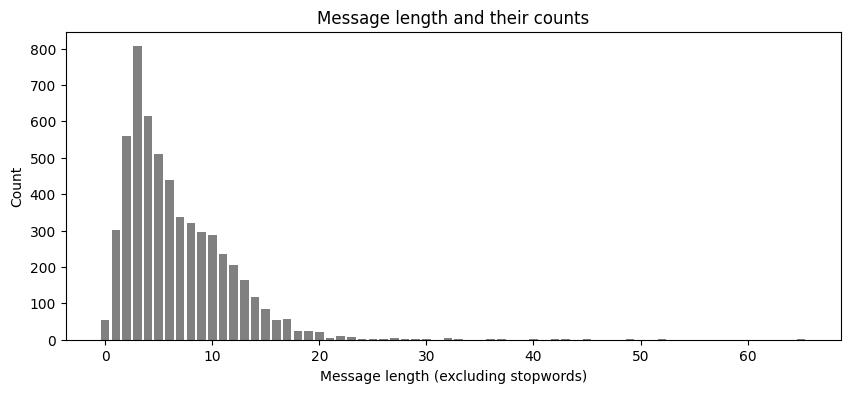

In [107]:
plt.figure(figsize = (10, 4))
plt.bar([item for item in message_length_count], [message_length_count[item] for item in message_length_count], color = 'grey')
plt.xlabel('Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Message length and their counts')

Text(0.5, 1.0, 'Spam Message length and their counts')

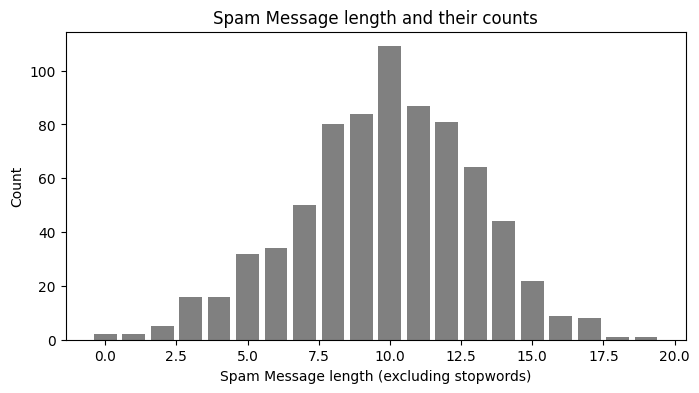

In [108]:
plt.figure(figsize = (8, 4))
plt.bar([item for item in spam_message_length_count], [spam_message_length_count[item] for item in spam_message_length_count], color = 'grey')
plt.xlabel('Spam Message length (excluding stopwords)')
plt.ylabel('Count')
plt.title('Spam Message length and their counts')

Looks like message length of 10 words is the most frequent among spam messages.

In [109]:
data_messages = [data[1] for data in data_normalized]
data_labels = [data[0] for data in data_normalized]
X_train, X_test, y_train, y_test = train_test_split(data_messages, data_labels, test_size = 0.3)

In [110]:
window_size = 3
context_size_half = int((window_size - 1) / 2)
embedding_size = 15

one_hot_map = {}
for i, word in enumerate(words_set):
  one_hot_map[word] = np.zeros(vocab_size)
  one_hot_map[word][i] = 1

def create_features(X, one_hot_map, context_size_half):
  features = []
  target = []

  for message in X:
    words = nltk.word_tokenize(message)
    for i in range(context_size_half, len(words) - context_size_half):
      target.append(one_hot_map[words[i]])
      feature = []
      for k in range(1, context_size_half + 1):
        feature.append(one_hot_map[words[i - k]])
        feature.append(one_hot_map[words[i + k]])
      features.append(feature)
  return features, target

features, target = create_features(X_train, one_hot_map, context_size_half)

def build_nn(features, target, hidden_units, vector_size):
  input1 = tf.keras.Input(shape = (vector_size,), name = 'input1')
  input2 = tf.keras.Input(shape = (vector_size,), name = 'input2')
  shared_embed = tf.keras.layers.Dense(hidden_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05), name = "embedded_layer")
  h1 = shared_embed(input1)
  h2 = shared_embed(input2)
  h = tf.keras.layers.Lambda(lambda z: (z[0] + z[1]) / 2.0)([h1, h2])
  output = tf.keras.layers.Dense(vector_size, activation='linear', name='output')(h)
  model = tf.keras.Model(inputs=[input1, input2], outputs=output)
  return model

model = build_nn(features, target, hidden_units=embedding_size, vector_size = vocab_size)
print(model.summary())

def train_nn(model, features, target):
  best_model_filepath = './best_model.keras'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = best_model_filepath,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    verbose = 1
  )

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])
  history = model.fit(features, target, epochs = 20, validation_split=0.1, callbacks = [model_checkpoint_callback])
  best_model = tf.keras.models.load_model(best_model_filepath, safe_mode=False)
  return best_model, history

feature1 = np.array([feature_i[0] for feature_i in features])
feature2 = np.array([feature_i[1] for feature_i in features])
target_np = np.array(target)
best_model, history = train_nn(model, [feature1, feature2], target_np)

best_model_weights = np.array(best_model.get_layer("embedded_layer").get_weights()[0])

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3608)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedded_layer      │ (None, 15)        │     54,135 │ input1[0][0],     │
│ (Dense)             │                   │            │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 15)        │          0 │ embedded_layer[0… │
│                     │                   │            │ embedded_layer[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 3608)      │     57,728 │ lambda_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,863 (436.96 KB)

 Trainable params: 111,863 (436.96 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
516/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0247 - loss: 8.9095
Epoch 1: val_loss improved from inf to 8.12738, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0248 - loss: 8.9057 - val_accuracy: 0.0352 - val_loss: 8.1274
Epoch 2/20
518/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0382 - loss: 8.0745
Epoch 2: val_loss improved from 8.12738 to 7.95483, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0382 - loss: 8.0742 - val_accuracy: 0.0352 - val_loss: 7.9548
Epoch 3/20
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0378 - loss: 7.8786
Epoch 3: val_loss improved from 7.95483 to 7.77003, saving model to ./best_model.keras
520/520 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0378 - loss: 7.8784 - val_accuracy: 0.0352 - val_loss: 7.7700
Epoch 4/20
519/520 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0372 - loss: 7.6642
Epoch 4: val_loss improved from 7.77003 to

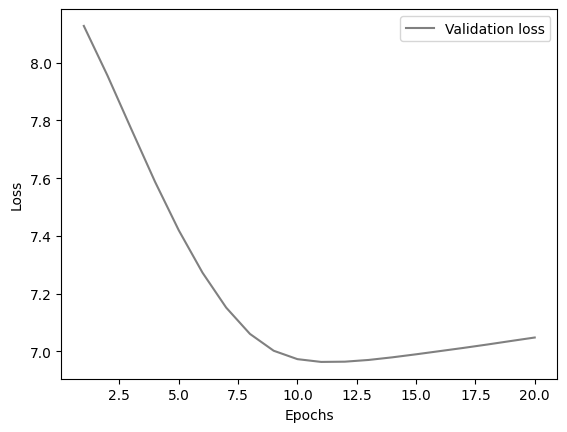

In [111]:
# Plotting validation loss over the epochs
val_loss = history.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [112]:
# Get word embeddings from weights
def get_word_embeddings(one_hot_map, best_model_weights):
  word_embeddings = {}
  for word in one_hot_map:
    one_hot_word = one_hot_map[word]
    embedded_word = np.dot(best_model_weights.T, one_hot_word)
    word_embeddings[word] = embedded_word
  return word_embeddings

word_embeddings = get_word_embeddings(one_hot_map, best_model_weights)

In [113]:
def get_classifier_features_and_labels(X, y):
  feature_words = []
  target_labels = []
  for i in range(len(X)):
    message = X[i]
    target_labels.append(y[i])
    words = message.split()
    message_length = len(words)
    words_needed = []
    if(message_length >= 10):
      words_needed = words[:10]
    else:
      words_needed = words
      remaining_words = 10 - len(words)
      for j in range(remaining_words):
        words_needed.append('')
    feature_words.append(words_needed)
  return feature_words, target_labels

feature_words, target_labels = get_classifier_features_and_labels(X_train, y_train)
print(feature_words)
print(target_labels)

[['neither', 'voice', 'fine', 'sure', 'thing', 'resolve', 'tho', 'anyway', '', ''], ['nothing', '', '', '', '', '', '', '', '', ''], ['yep', 'fine', 'ice', 'age', '', '', '', '', '', ''], ['full', '', '', '', '', '', '', '', '', ''], ['ok', 'take', 'care', '', '', '', '', '', '', ''], ['wow', 'healthy', 'old', 'airport', 'cant', 'anything', 'else', 'b', 'bath', 'dog'], ['one', '', '', '', '', '', '', '', '', ''], ['brother', 'pa', '', '', '', '', '', '', '', ''], ['dear', 'voucher', 'holder', 'claim', 'offer', 'go', 'e', 'apply', 'stop', 'stop'], ['per', 'min', 'call', 'line', 'per', 'min', 'check', 'c', 'text', 'stop'], ['tough', '', '', '', '', '', '', '', '', ''], ['lay', 'line', 'rest', '', '', '', '', '', '', ''], ['b', 'still', 'get', 'conclusion', 'n', 'content', 'n', 'b', 'da', 'content'], ['vote', 'wherever', 'heart', '', '', '', '', '', '', ''], ['different', 'go', 'try', 'find', 'every', 'real', 'life', 'photo', 'ever', 'take'], ['let', 'ur', 'heart', 'ur', 'compass', 'ur', 

In [114]:
def get_classifier_features_and_labels_encoded(feature_words, target_labels):
  feature_embedded_words = []
  target_encoded = []

  for i in range(len(feature_words)):
    message_words = feature_words[i]
    message_words_embedded = []
    label = 1 if target_labels[i] == 'spam' else 0
    target_encoded.append(label)
    for word in message_words:
      if(word == ''):
        word_embedded = np.zeros(embedding_size)
      else:
        word_embedded = word_embeddings[word]
      message_words_embedded.append(word_embedded)
    feature_embedded_words.append(message_words_embedded)

  feature_embedded_words = np.array(feature_embedded_words)
  target_encoded = np.array(target_encoded)
  return feature_embedded_words, target_encoded

feature_embedded_words, target_encoded = get_classifier_features_and_labels_encoded(feature_words, target_labels)
print(feature_embedded_words.shape)
print(target_encoded.shape)

(3900, 10, 15)
(3900,)


In [115]:
def build_spam_classifier(features):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (10, 15)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 3, activation = 'relu'),
      tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
  print(model.summary())
  return model

best_classifier_filepath = './best_classifier.keras'
classifier_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath = best_classifier_filepath,
  monitor = 'val_loss',
  mode = 'min',
  save_best_only = True,
  verbose = 1
)

classifier = build_spam_classifier(feature_embedded_words)
classifier_history = classifier.fit(feature_embedded_words, target_encoded, epochs = 40, validation_split=0.1, callbacks = [classifier_checkpoint_callback])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           453 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457 (1.79 KB)

 Trainable params: 457 (1.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
 95/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.6811
Epoch 1: val_loss improved from inf to 0.62657, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8688 - loss: 0.6789 - val_accuracy: 0.8897 - val_loss: 0.6266
Epoch 2/40
 95/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8572 - loss: 0.6148
Epoch 2: val_loss improved from 0.62657 to 0.54153, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8593 - loss: 0.6115 - val_accuracy: 0.8897 - val_loss: 0.5415
Epoch 3/40
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.5284
Epoch 3: val_loss improved from 0.54153 to 0.46579, saving model to ./best_classifier.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8746 - loss: 0.5275 - val_accuracy: 0.8897 - val_loss: 0.4658
Epoch 4/40
 88/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.4623
Epoch 4: val_loss improved f

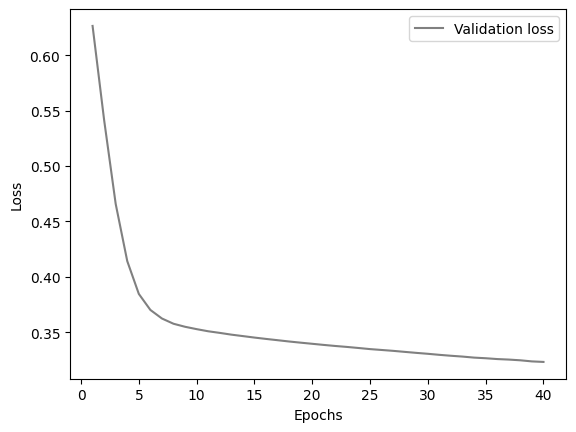

In [116]:
# Plotting validation loss over the epochs
classifier_val_loss = classifier_history.history['val_loss']
epochs = range(1, len(classifier_val_loss) + 1)
plt.plot(epochs, classifier_val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [117]:
# Test
features_test, target_test = create_features(X_test, one_hot_map, context_size_half)
model_test = build_nn(features_test, target_test, hidden_units=embedding_size, vector_size = vocab_size)

feature1_test = np.array([feature_i[0] for feature_i in features_test])
feature2_test = np.array([feature_i[1] for feature_i in features_test])
target_np_test = np.array(target_test)
best_model_test, history_test = train_nn(model_test, [feature1_test, feature2_test], target_np_test)

best_model_weights_test = np.array(best_model_test.get_layer("embedded_layer").get_weights()[0])

Epoch 1/20
214/219 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0238 - loss: 9.2357
Epoch 1: val_loss improved from inf to 8.42246, saving model to ./best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0240 - loss: 9.2266 - val_accuracy: 0.0284 - val_loss: 8.4225
Epoch 2/20
214/219 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0358 - loss: 8.3252
Epoch 2: val_loss improved from 8.42246 to 8.15879, saving model to ./best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0359 - loss: 8.3233 - val_accuracy: 0.0335 - val_loss: 8.1588
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0387 - loss: 8.1175
Epoch 3: val_loss improved from 8.15879 to 8.06749, saving model to ./best_model.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0387 - loss: 8.1173 - val_accuracy: 0.0335 - val_loss: 8.0675
Epoch 4/20
213/219 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0336 - loss: 8.0174
Epoch 4: val_loss improved from 8.06749 to 7.9

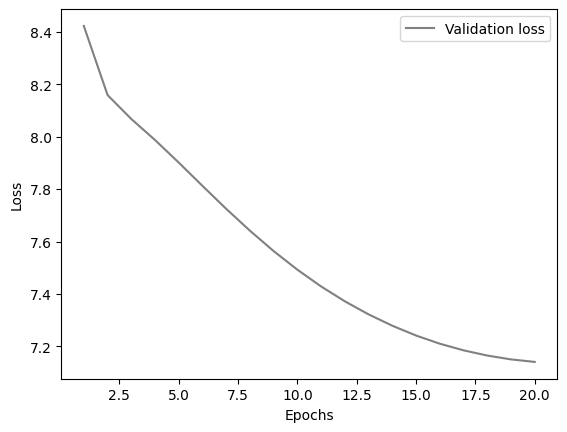

In [118]:
# Plotting validation loss over the epochs
val_loss = history_test.history['val_loss']
epochs = range(1, len(val_loss) + 1)
plt.plot(epochs, val_loss, color = 'grey', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [119]:
# Predictions for test data
word_embeddings_test = get_word_embeddings(one_hot_map, best_model_weights_test)
feature_words_test, target_labels_test = get_classifier_features_and_labels(X_test, y_test)
feature_embedded_words_test, target_encoded_test = get_classifier_features_and_labels_encoded(feature_words_test, target_labels_test)
print(feature_embedded_words_test.shape)
print(target_encoded_test.shape)

target_pred = classifier.predict(feature_embedded_words_test)
target_pred_binary = [1 if x > 0.5 else 0 for x in target_pred]
print(target_pred_binary)
print(target_encoded_test)

(1672, 10, 15)
(1672,)
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [120]:
def get_result(target_pred_binary, target_encoded_test):
  matches_1 = 0
  matches_0 = 0
  false_positives = 0
  true_negatives = 0
  for x in range(len(target_pred_binary)):
    if(target_pred_binary[x] == target_encoded_test[x]):
      if(target_pred_binary[x] == 1):
        matches_1 += 1
      elif(target_pred_binary[x] == 0):
        matches_0 += 1
    elif((target_pred_binary[x] == 1) and (target_encoded_test[x] == 0)):
      false_positives += 1
    elif((target_pred_binary[x] == 0) and (target_encoded_test[x] == 1)):
      true_negatives += 1
  print(f"Correct(Actual: Spam, Predicted: Spam) = {matches_1}")
  print(f"Correct(Actual: Non-Spam, Predicted: Non-Spam) = {matches_0}")
  print(f"Error(Actual: Non-Spam, Predicted: Spam) = {false_positives}")
  print(f"Error(Actual: Spam, Predicted: Non-Spam) = {true_negatives}")
  pivot_table = [[matches_0, false_positives], [true_negatives, matches_1]]
  pivot_df = pd.DataFrame(pivot_table, columns = [0, 1], index = [0, 1])
  print("\nConfusion Matrix")
  return pivot_df
get_result(target_pred_binary, target_encoded_test)

Correct(Actual: Spam, Predicted: Spam) = 0
Correct(Actual: Non-Spam, Predicted: Non-Spam) = 1418
Error(Actual: Non-Spam, Predicted: Spam) = 0
Error(Actual: Spam, Predicted: Non-Spam) = 254

Confusion Matrix


,0,1
0,1418,0
1,254,0


In [121]:
# Predictions of train data
target_pred_train = classifier.predict(feature_embedded_words)
target_pred_train_binary = [1 if x > 0.5 else 0 for x in target_pred_train]
get_result(target_pred_train_binary, target_encoded)

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correct(Actual: Spam, Predicted: Spam) = 0
Correct(Actual: Non-Spam, Predicted: Non-Spam) = 3407
Error(Actual: Non-Spam, Predicted: Spam) = 0
Error(Actual: Spam, Predicted: Non-Spam) = 493

Confusion Matrix


,0,1
0,3407,0
1,493,0
